<a href="https://colab.research.google.com/github/PragatiDebata/BDSN/blob/main/BDSN_A21022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BDSN ASSIGNMENT

### **Research Objective**: To discover the clusters of Uber data based on the longitude and latitude, then we will analyze the cluster centers by date/time.

To start our spark environment we will install JAVA at first.

In [1]:
!apt update > /dev/null
!apt install openjdk-8-jdk-headless -qq > /dev/null

We will create spark environment and in the next cell we will import all the libraries needed for this project.

In [2]:
# Get latest and correct version of Spark
#
# if the current version of Spark is not used, there may be errors
# check here for current versions http://apache.osuosl.org/spark
#
#!wget -q http://apache.osuosl.org/spark/spark-2.2.2/spark-2.2.2-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
#!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

#!tar xf spark-2.4.5-bin-hadoop2.7.tgz
#!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
#!pip install -q findspark
!pip install -q pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
#os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"


     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 44.6 MB/s 


In [3]:
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
# note UI port switched from default 4040 to 4050 to avoid clash with ngrok
spark = SparkSession.builder.master("local[*]").config('spark.ui.port', '4050').getOrCreate()

In [4]:
sc = spark.sparkContext

In [5]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

Importing all the libaries

In [55]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.sql.functions import isnan, when, count, col
import numpy as np

# Visualization

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Setting random seed for notebook reproducability

In [8]:

rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

### Dataset: Importing the dataset from drive.

Our data is Uber trip data from http://data.beta.nyc/dataset/uber-trip-data-foiled-apr-sep-2014. In this, we will discover the clusters of Uber data based on the longitude and latitude, then we will analyze the cluster centers by date/time.

In [9]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/uber.csv')

In [10]:
df.head()

,2014-08-01 00:00:00,40.729,-73.9422,B02598
0,2014-08-01 00:00:00,40.7476,-73.9871,B02598
1,2014-08-01 00:00:00,40.7424,-74.0044,B02598
2,2014-08-01 00:00:00,40.7510,-73.9869,B02598
3,2014-08-01 00:00:00,40.7406,-73.9902,B02598
4,2014-08-01 00:00:00,40.6994,-73.9591,B02617


In [11]:
UBER_DATA = '/content/drive/MyDrive/Colab Notebooks/uber.csv'

In [12]:
schema = StructType([
    StructField("dt", TimestampType(), nullable=False),
    StructField("lat", DoubleType(), nullable=False),
    StructField("lon", DoubleType(), nullable=False),
    StructField("base", StringType(), nullable=True)]
  )

Cache means to load the dataset in Cache memory.
We can load the results quickly when various different functions are applied on as Cache memory is the fastest available memory.

In [13]:
uber_df = spark.read.csv(path=UBER_DATA, schema=schema)
uber_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string]

The first 5 rows of our data

In [14]:
uber_df.show(5)

+-------------------+-------+--------+------+
|                 dt|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-08-01 00:00:00| 40.729|-73.9422|B02598|
|2014-08-01 00:00:00|40.7476|-73.9871|B02598|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|
|2014-08-01 00:00:00| 40.751|-73.9869|B02598|
|2014-08-01 00:00:00|40.7406|-73.9902|B02598|
+-------------------+-------+--------+------+
only showing top 5 rows



The data set has the following schema:

In [15]:
uber_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [16]:
uber_df.count()

829275

# Statistics Summary

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame. Lets use it and see what all we get 

In [17]:
uber_df.describe(["dt", "lat", "lon"]).show()

+-------+--------------------+-------------------+
|summary|                 lat|                lon|
+-------+--------------------+-------------------+
|  count|              829275|             829275|
|   mean|   40.73778073582407| -73.97016031317641|
| stddev|0.043628060846854146|0.06148272834515576|
|    min|             39.6569|           -74.7737|
|    max|             41.3182|           -72.3359|
+-------+--------------------+-------------------+



In [18]:
feature_columns = ['lat', 'lon']

Vectorizing the numerical features first

In [19]:
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [20]:
uber_assembled_df = feature_assembler.transform(uber_df)
uber_assembled_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [21]:
uber_assembled_df.show(5)

+-------------------+-------+--------+------+------------------+
|                 dt|    lat|     lon|  base|          features|
+-------------------+-------+--------+------+------------------+
|2014-08-01 00:00:00| 40.729|-73.9422|B02598| [40.729,-73.9422]|
|2014-08-01 00:00:00|40.7476|-73.9871|B02598|[40.7476,-73.9871]|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|[40.7424,-74.0044]|
|2014-08-01 00:00:00| 40.751|-73.9869|B02598| [40.751,-73.9869]|
|2014-08-01 00:00:00|40.7406|-73.9902|B02598|[40.7406,-73.9902]|
+-------------------+-------+--------+------+------------------+
only showing top 5 rows



### Split into Training and Testing Set:

In [22]:
train_df, test_df = uber_assembled_df.randomSplit([0.7, 0.3], seed=rnd_seed)

In [23]:
train_df.cache()
test_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

Removing the not needed dataframes

In [24]:
uber_df.unpersist()
uber_assembled_df.unpersist()

DataFrame[dt: timestamp, lat: double, lon: double, base: string]

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [62]:
uber_df.show(5)

+-------------------+-------+--------+------+
|                 dt|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-08-01 00:00:00| 40.729|-73.9422|B02598|
|2014-08-01 00:00:00|40.7476|-73.9871|B02598|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|
|2014-08-01 00:00:00| 40.751|-73.9869|B02598|
|2014-08-01 00:00:00|40.7406|-73.9902|B02598|
+-------------------+-------+--------+------+
only showing top 5 rows



**# K-Means Clustering**

k-means is one of the most popular clustering algorithms. In this algorithm, a user-specified number of clusters (k) are randomly assigned to different points in the dataset.

Choosing the right value for k is an extremely important aspect of using this algorithm successfully. There is no real prescription for the number of clusters you need, so we will likely have to experiment with different values and consider what we would like the end result to be.

In [25]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

Train k-Means:

In [26]:
kmeans = KMeans(k=8, initMode='k-means||', featuresCol='features', predictionCol='cluster', maxIter=10)

In [27]:
kmModel = kmeans.fit(train_df)

In [28]:
print("KMeans Cluster Centers: ")
for center in kmModel.clusterCenters():
    print(center)

KMeans Cluster Centers: 
[ 40.7611 -73.8722]
[ 40.7693 -73.97  ]
[ 40.6865 -73.9639]
[ 40.766  -73.4801]
[ 40.905  -73.8711]
[ 40.6562 -73.7797]
[ 40.7324 -73.9971]
[ 40.6997 -74.2005]


Predicting

In [29]:
test_preds = kmModel.transform(test_df)
test_preds.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector, cluster: int]

In [30]:
test_preds.show(5)

+-------------------+-------+--------+------+------------------+-------+
|                 dt|    lat|     lon|  base|          features|cluster|
+-------------------+-------+--------+------+------------------+-------+
|2014-08-01 00:00:00|40.6754| -74.017|B02682| [40.6754,-74.017]|      2|
|2014-08-01 00:00:00|40.6982|-73.9669|B02617|[40.6982,-73.9669]|      2|
|2014-08-01 00:00:00|40.7063|-73.9223|B02617|[40.7063,-73.9223]|      2|
|2014-08-01 00:00:00|40.7134|-74.0091|B02682|[40.7134,-74.0091]|      6|
|2014-08-01 00:00:00|40.7303|-74.0029|B02682|[40.7303,-74.0029]|      6|
+-------------------+-------+--------+------+------------------+-------+
only showing top 5 rows



k-means includes a summary class that we can use to evaluate our model. This class provides some common measures for k-means success (whether these apply to our problem set is another question). The k-means summary includes information about the clusters created, as well as their relative sizes (number of examples).

In [31]:
print(kmModel.summary.clusterSizes)

[26431, 185757, 87002, 1657, 7060, 18311, 248176, 6055]


# Let's do some DATA EXPLORATION using spark SQL

We can use Spark SQL to explore the dataset. Here are some example queries using the Spark SQL.

In [32]:
test_preds.createOrReplaceTempView("test_preds")

In [33]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

Suppose we want to answer:
## Which hours of the day and which cluster had the highest number of pickups?

In [34]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    cluster,
                          |    COUNT(*) as count
                          |FROM test_preds
                          |GROUP BY hour, cluster
                          |ORDER BY count DESC
                        """))
sql_result_df.cache()

DataFrame[hour: int, cluster: int, count: bigint]

In [35]:
sql_result_df.show(5)

+----+-------+-----+
|hour|cluster|count|
+----+-------+-----+
|  17|      6| 7814|
|  18|      6| 7334|
|  16|      6| 7007|
|  19|      6| 6938|
|  21|      6| 6798|
+----+-------+-----+
only showing top 5 rows



The graph will help us know the hours with maximum number of pickups.

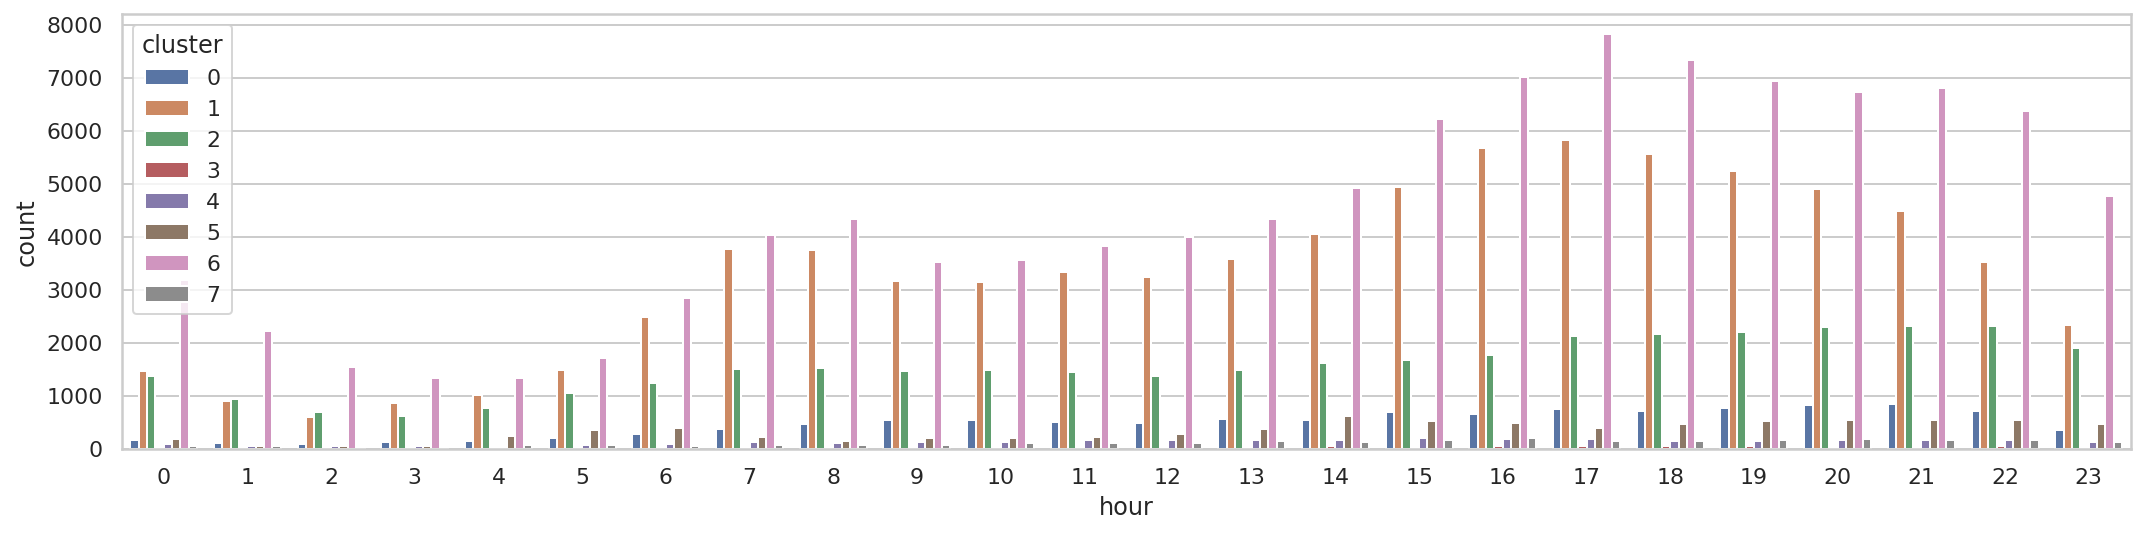

In [36]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", hue="cluster", data=sql_result_df.toPandas());

## How many pickups occurred in each cluster?

In [37]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT cluster, COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY cluster
                          |ORDER BY cluster
                        """))
sql_result_df.cache()

DataFrame[cluster: int, count: bigint]

In [38]:
sql_result_df.show(5)

+-------+-----+
|cluster|count|
+-------+-----+
|      0|11378|
|      1|79244|
|      2|37293|
|      3|  707|
|      4| 3016|
+-------+-----+
only showing top 5 rows



Cluster 3 has maximum pickups

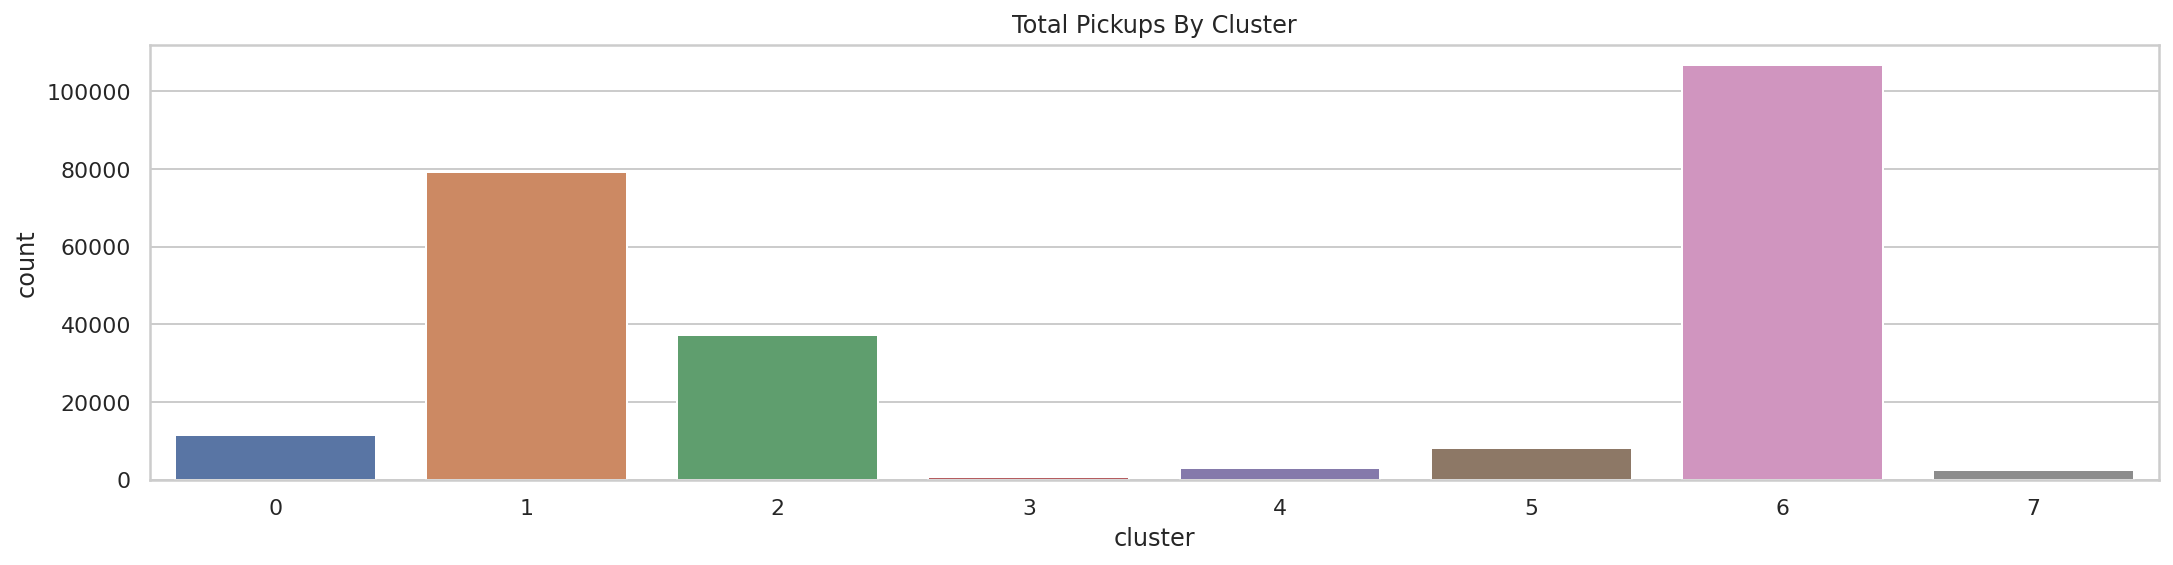

In [39]:
plt.figure(figsize=(18,4))
sns.barplot(x="cluster", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Cluster");

## How many pickups occurred in each hour?

In [40]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY hour
                          |ORDER BY hour
                        """))
sql_result_df.cache()

DataFrame[hour: int, count: bigint]

In [41]:
sql_result_df.show(5)

+----+-----+
|hour|count|
+----+-----+
|   0| 6511|
|   1| 4320|
|   2| 3010|
|   3| 3044|
|   4| 3579|
+----+-----+
only showing top 5 rows



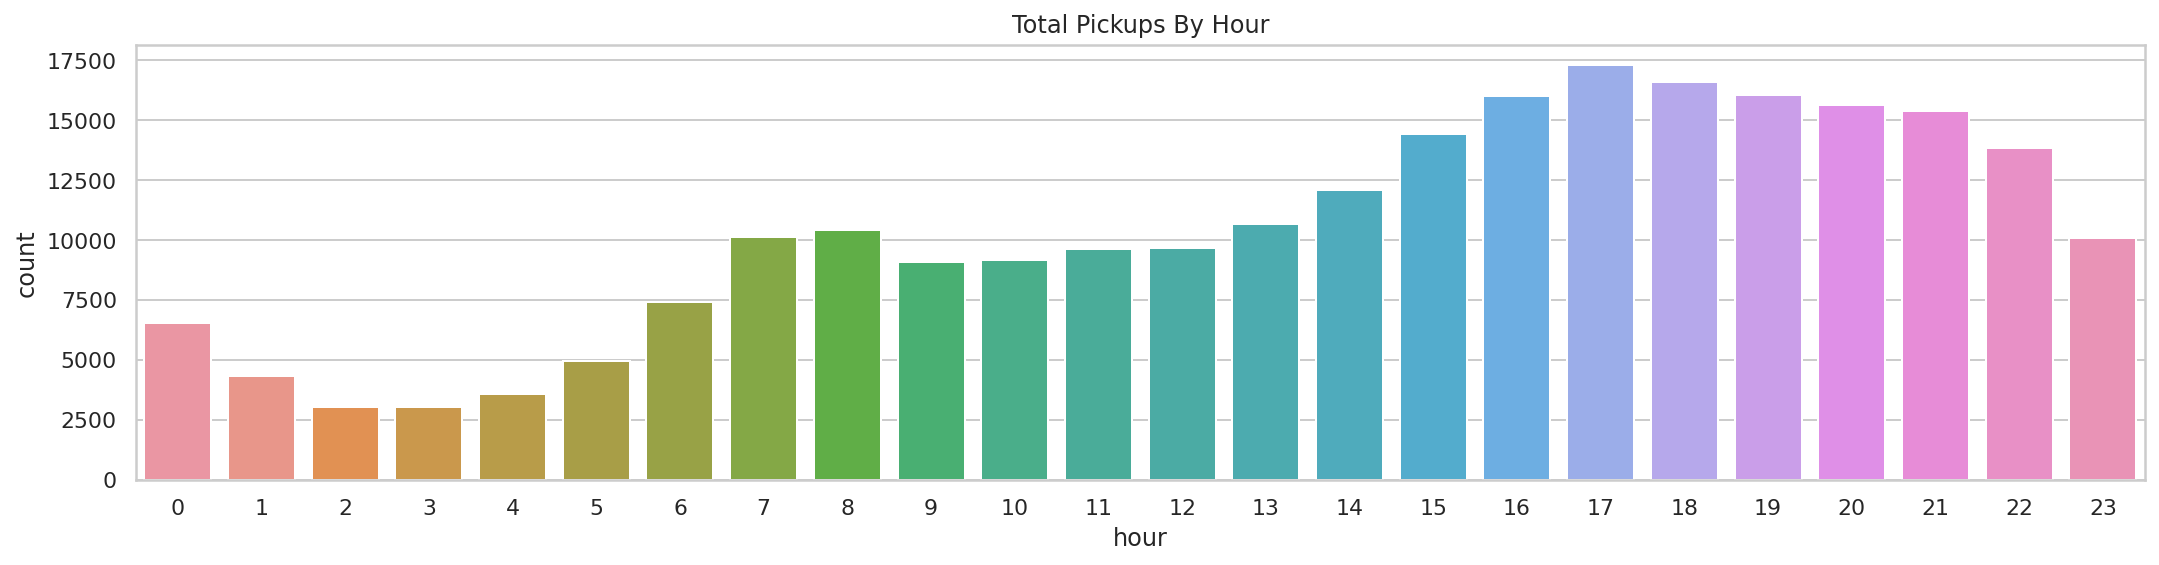

In [42]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Hour");

## Gaussian Mixture Models 

Gaussian mixture models (GMM) are another clustering algorithm that try to group data by reducing the sum of squared distances from the center of the cluster. Gaussian mixture models assume that each cluster produces data based upon random draws from a Gaussian distribution. 

In [43]:
gmm = GaussianMixture(featuresCol='features', predictionCol='cluster', k=8)

In [44]:
gmm.explainParams()

'aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nfeaturesCol: features column name. (default: features, current: features)\nk: Number of independent Gaussians in the mixture model. Must be > 1. (default: 2, current: 8)\nmaxIter: max number of iterations (>= 0). (default: 100)\npredictionCol: prediction column name. (default: prediction, current: cluster)\nprobabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)\nseed: random seed. (default: -7930192455587573950)\ntol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.01)\nweightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)'

In [45]:
gmmModel = gmm.fit(train_df)

In [46]:
gmmModel.transform(test_df).show(5)

+-------------------+-------+--------+------+------------------+--------------------+-------+
|                 dt|    lat|     lon|  base|          features|         probability|cluster|
+-------------------+-------+--------+------+------------------+--------------------+-------+
|2014-08-01 00:00:00|40.6754| -74.017|B02682| [40.6754,-74.017]|[0.01651681562722...|      1|
|2014-08-01 00:00:00|40.6982|-73.9669|B02617|[40.6982,-73.9669]|[0.04109997177197...|      5|
|2014-08-01 00:00:00|40.7063|-73.9223|B02617|[40.7063,-73.9223]|[0.28313398784207...|      5|
|2014-08-01 00:00:00|40.7134|-74.0091|B02682|[40.7134,-74.0091]|[0.01263642997046...|      4|
|2014-08-01 00:00:00|40.7303|-74.0029|B02682|[40.7303,-74.0029]|[0.00900845633139...|      4|
+-------------------+-------+--------+------+------------------+--------------------+-------+
only showing top 5 rows



# Gaussian Mixture Model Summary
Like our k-means clustering algorithm, Gaussian mixture models include a summary class to help with model evaluation. This includes information about the clusters created, like the weights, the means, and the covariance of the Gaussian mixture, which can help us learn more about the underlying structure inside of our data:

In [47]:
gmmModel.weights

[0.06344261362392324,
 0.0359304395523446,
 0.07520962320323114,
 0.10691410992080919,
 0.5255596609254812,
 0.14360127260109098,
 0.019438069333575034,
 0.02990421083954458]

In [48]:
gmmModel.gaussiansDF.limit(5).toPandas()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,mean,cov
0,"[40.740014200830174, -73.93463301211749]","DenseMatrix([[0.0008, 0. ],\n [0. , 0.0046]])"
1,"[40.657253214254254, -73.88341579302305]","DenseMatrix([[ 0.0004, -0.0029],\n [-0.0029, 0.0246]])"
2,"[40.76726598643045, -73.96701765053164]","DenseMatrix([[0.0031, 0.0013],\n [0.0013, 0.0006]])"
3,"[40.76335485981282, -73.96624313740337]","DenseMatrix([[0.0001, 0.0001],\n [0.0001, 0.0001]])"
4,"[40.741652398419426, -73.99258653908463]","DenseMatrix([[0.0004, 0.0002],\n [0.0002, 0.0001]])"


In [49]:
print(gmmModel.summary.clusterSizes)

[26123, 20524, 21304, 67820, 332129, 87621, 11343, 13585]


In [50]:
gmmModel.summary.cluster.show(10)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------+
|cluster|
+-------+
|      7|
|      7|
|      1|
|      5|
|      0|
|      5|
|      4|
|      4|
|      5|
|      4|
+-------+
only showing top 10 rows



In [51]:
gmmModel.summary.probability.limit(5).toPandas()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,probability
0,"[7.059804429960573e-14, 7.059804429960573e-14, 7.059804636572728e-14, 7.059804429960573e-14, 7.059804429960573e-14, 7.059804429960573e-14, 7.059804429960573e-14, 0.9999999999995058]"
1,"[7.059804429960573e-14, 7.059804429960573e-14, 7.059804636572728e-14, 7.059804429960573e-14, 7.059804429960573e-14, 7.059804429960573e-14, 7.059804429960573e-14, 0.9999999999995058]"
2,"[0.018698858175506813, 0.44357404596492267, 0.22188981733583626, 4.865836149360202e-17, 0.1972489783781144, 0.10906431964965188, 1.8068644022585925e-17, 0.009523980495968101]"
3,"[0.06290784610489784, 1.0908272273109552e-17, 6.912807042834943e-09, 1.090827227303344e-17, 3.6814924208005386e-15, 0.9302031855170729, 1.090827227303344e-17, 0.006888961465218409]"
4,"[0.5985069241089854, 8.654532440969709e-17, 8.834499609634277e-17, 8.654532440969709e-17, 8.65453244097164e-17, 0.34505198692237216, 8.654532440969709e-17, 0.05644108896864189]"
